In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
%matplotlib inline

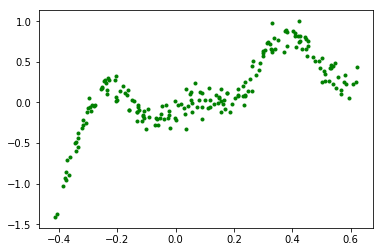

In [2]:
x = np.linspace(0,1,200)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(x, y, marker='.', color='g')

## creating the layer

In [3]:
class ProbLayer(tnn.Layer):
    
    def __init__(self, input_dim, output_dim, prob_dim=2, optimizer=tnn.SGD()):
        self.input = None
        self.output = None
        self.del_output = None
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prob_dim = prob_dim
        
        self.probability = tnn.NonLinearLayer(1, output_dim*prob_dim, 
                                             activation=tnn.Gaussian(), optimizer=optimizer)
        self.regression = tnn.LinearLayer(1, output_dim*prob_dim, 
                                         optimizer=optimizer)
        
    def forward(self, input):
        probs = self.probability.forward(xx)
        regs = self.regression.forward(xx)
        a1 = probs*regs
        a1 = a1.reshape(-1,self.output_dim, self.prob_dim)
        y_out = a1.sum(axis=-1)
#         print(y_out.shape)
        self.output = y_out
        return self.output
    
    def backward(self, del_output):
        self.del_output = del_output
        da1 = np.hstack([del_output]*self.prob_dim).reshape(-1, self.output_dim*self.prob_dim)
#         print(da1.shape, self.regression.zee.shape)
        
        dxprobs = self.probability.backward(da1*self.regression.zee)
        dxregs = self.regression.backward(da1*self.probability.output)
        del_input = dxprobs + dxregs
        return del_input
    
    def update(self):
        self.probability.update()
        self.regression.update
        
        
class SprobLayer(tnn.Layer):
    
    def __init__(self, input_dim, output_dim, prob_dim=2, optimizer=tnn.SGD()):
        self.input = None
        self.output = None
        self.del_output = None
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prob_dim = prob_dim
        
        self.probability = tnn.NonLinearLayer(1, output_dim*prob_dim, 
                                             activation=tnn.Gaussian(), optimizer=optimizer)
        self.scaler = tnn.BiasLayer(output_dim*prob_dim, 
                                         optimizer=optimizer)
        
    def forward(self, input):
        probs = self.probability.forward(xx)
        scale = self.scaler.forward(0)
        a1 = probs*scale
        a1 = a1.reshape(-1,self.output_dim, self.prob_dim)
        y_out = a1.sum(axis=-1)
#         print(y_out.shape)
        self.output = y_out
        return self.output
    
    def backward(self, del_output):
        self.del_output = del_output
        da1 = np.hstack([del_output]*self.prob_dim).reshape(-1, self.output_dim*self.prob_dim)
#         print(da1.shape, self.regression.zee.shape)
        
        dxprobs = self.probability.backward(da1*self.scaler.output)
        dxregs = self.scaler.backward(da1*self.probability.output)
        del_input = dxprobs #+ dxregs
        return del_input
    
    def update(self):
        self.probability.update()
        self.scaler.update()

In [6]:
optimizer = tnn.Adam(learning_rate=0.01)
net = SprobLayer(1,1, prob_dim=3, optimizer=optimizer)

In [7]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.ion()
fig.show()
fig.canvas.draw()

for step in range(100000):
    y_out = net.forward(xx)

    loss = tnn.MseLoss.loss(y_out, yy)
    dy = tnn.MseLoss.del_loss(y_out, yy)
    
    dx = net.backward(dy)
    net.update()
    
    if step % 100 == 0:

        print('_______________________')
        print("epoch", step)
        print("Loss", loss)

        ax.clear()
        plt.scatter(x, y, marker='.', c='g', label='x,y')
        plt.scatter(x, y_out.reshape(-1), marker='.', c='r', lw=3, label='x,a1')
#         plt.scatter(x, dx.reshape(-1), marker='*', c='c', lw=1, label='x,dx')
        plt.scatter(x, dy.reshape(-1), marker='.', c='m', lw=1, label='x,dy')
        plt.plot(x, np.zeros_like(x), c='b', lw=2)
        plt.legend()
        
        fig.canvas.draw()
        
        plt.pause(0.01)
        print()
        if loss < 0.0025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
epoch 0
Loss 0.09469586851574058

_______________________
epoch 100
Loss 0.0535697653798418

_______________________
epoch 200
Loss 0.03710328229649257

_______________________
epoch 300
Loss 0.03585663861412983

_______________________
epoch 400
Loss 0.033969604633142116

_______________________
epoch 500
Loss 0.03203874972406787

_______________________
epoch 600
Loss 0.02990578302133927

_______________________
epoch 700
Loss 0.023636109123289985

_______________________
epoch 800
Loss 0.016696485990500783

_______________________
epoch 900
Loss 0.012623889766022436

_______________________
epoch 1000
Loss 0.010645057356122138

_______________________
epoch 1100
Loss 0.009710164735561072

_______________________
epoch 1200
Loss 0.009251410748089857

_______________________
epoch 1300
Loss 0.009014357926585649

_______________________
epoch 1400
Loss 0.008885305634738749

_______________________
epoch 1500
Loss 0.0088117010965124

_______________________
epoch

TclError: invalid command name "pyimage33"

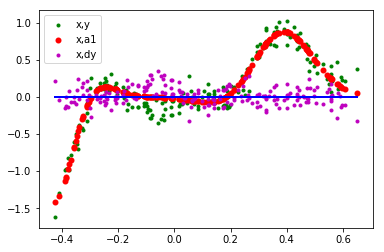

In [9]:
%matplotlib inline
plt.scatter(x, y, marker='.', c='g', label='x,y')
plt.scatter(x, y_out.reshape(-1), marker='.', c='r', lw=3, label='x,a1')
#         plt.scatter(x, dx.reshape(-1), marker='*', c='c', lw=1, label='x,dx')
plt.scatter(x, dy.reshape(-1), marker='.', c='m', lw=1, label='x,dy')
plt.plot(x, np.zeros_like(x), c='b', lw=2)
plt.legend()